In [4]:
# requirement
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv
from IPython import embed

## binary classification

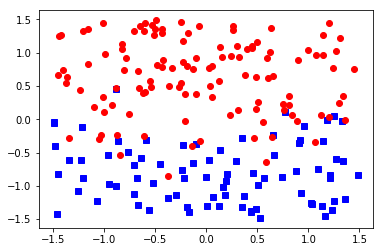

In [23]:
# Dataset IV
np.random.seed(123)
N = 200
D = 4
C = 3
x = 3 * (np.random.rand(N, D)-0.5) # [[-1.5, 1.5], [-1.5, 1.5]]の範囲でn個のdim=4の点を生成
y = (2*x[:,1] -  1*x[:,2] + 0.5 + 0.5*np.random.randn(N)) > 0
y = 2*y -1

plt.plot(x[y < 0, 0],  x[y < 0, 1], 'bs')
plt.plot(x[y > 0, 0],  x[y > 0, 1], 'ro')

In [6]:
# component
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# sigmoid = np.frompyfunc(sigmoid, 1, 1)

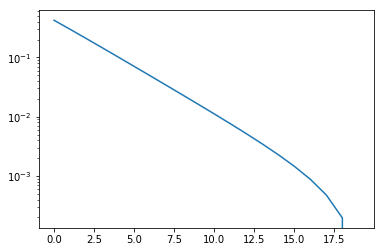

In [24]:
%matplotlib inline

def steepest_binary(x, y):
    """
    x: shape(N, D)
    y: shape:(N)
    """
    sigma = sigmoid(y * np.dot(x, w))  # shape(N)
    #loss = - np.average(np.log(sigma) - lmbd*np.dot(w, w))  # shape(1)
    loss = np.average(np.log(1 + np.exp(- y * np.dot(x, w))) + lmbd*np.dot(w, w))  # shape(1)
    grad = - np.dot(y*(1 - sigma), x)/N + 2*lmbd*w  # shape(D)
    return loss, grad

s_losses = []
s_weights = []
epoch_size = 20
lmbd = 0.1
w = np.random.randn(d)
eta = 0.5
for i in range(epoch_size):
    loss, grad = steepest_binary(x, y)
    w = w - eta*grad
    s_losses.append(loss)
    s_weights.append(w)

s_loss_diff = np.stack(s_losses) - loss
plt.plot(s_loss_diff)
plt.yscale('log')
plt.show()

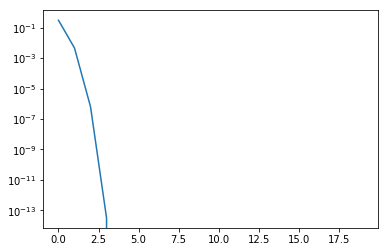

In [25]:
%matplotlib inline

def newton_binary(x, y):
    """
    x: shape(N, D)
    y: shape:(N)
    """
    sigma = sigmoid(y * np.dot(x, w))  # shape(N)
    loss = np.average(np.log(1 + np.exp(- y * np.dot(x, w))) + lmbd*np.dot(w, w))  # shape(1)
    grad = - np.dot(y*(1 - sigma), x)/N + 2*lmbd*w  # shape(D)
    hess = np.einsum('i, ij, ik', y**2 * sigma * (1-sigma), x, x)/N + 2*lmbd*np.identity(d)  # shape(D, D)
    # upd = np.linalg.solve(hess, -grad)
    upd = - np.dot(np.linalg.inv(hess), grad)
    return loss, upd

n_losses = []
n_weights = []
epoch_size = 20
lmbd = 0.1
w = np.random.randn(d)
for i in range(epoch_size):
    loss, upd = newton_binary(x, y)
    w = w + upd
    n_losses.append(loss)
    n_weights.append(w)

n_loss_diff = np.stack(n_losses) - loss
plt.plot(n_loss_diff)
plt.yscale('log')
plt.show()

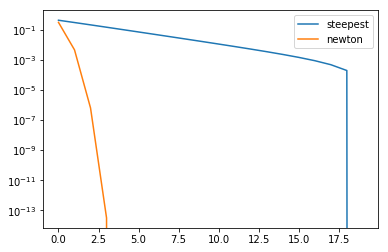

In [26]:
plt.plot(s_loss_diff, label='steepest')
plt.plot(n_loss_diff, label='newton')
plt.yscale('log')
plt.legend()
plt.show()

## multi-class classification

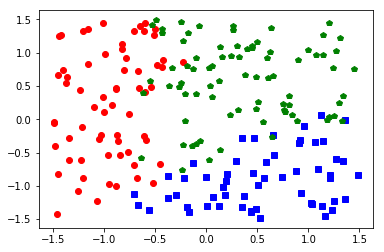

In [51]:
# Dataset V
np.random.seed(123)
N = 200
C = 3
D = 4
x = 3 * (np.random.rand(N, D) - 0.5) # [[-1.5, 1.5], [-1.5, 1.5]]の範囲でN個のdim=4の点を生成
W = np.array([[2, -1, 1.5],
                            [-3, 2, 1],
                            [1, 2, 3]])
y = np.argmax(np.dot(np.hstack([x[:,:2], np.ones((N, 1))]), W.T)
                        + 0.5 * np.random.randn(N, 3), axis=1)

plt.plot(x[y == 0, 0],  x[y == 0, 1], 'bs')
plt.plot(x[y == 1, 0],  x[y == 1, 1], 'ro')
plt.plot(x[y == 2, 0],  x[y == 2, 1], 'gp')

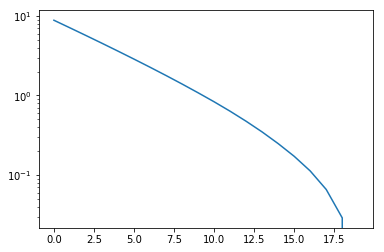

In [65]:
%matplotlib inline

def steepest_multiclass(x, y):
    outp = np.dot(x, w.T)
    maxclss = outp.argmax(axis=1)
    # loss = - np.einsum('ij,ij', x, w[y])/N + np.average(outp[np.arange(len(outp)), maxclss]) + lmbd * np.sum(w**2)  # shape(1)
    loss = (- np.sum(x * w[y]) + np.sum(outp[np.arange(N), maxclss])) / N + lmbd * np.sum(w**2)  # shape(1)
    grad = np.stack([- np.sum(x[y==i], axis=0) + np.sum(x[maxclss==i], axis=0) for i in range(class_size)]) / N + 2*lmbd*w # shape(C, D)
    return loss, grad, maxclss

N, D = x.shape
class_size = 3
epoch_size = 20
lmbd = 0.5
eta = 0.1

w = np.random.randn(class_size,4)
s_losses = []
s_weights = []
for i in range(epoch_size):
    loss, grad, maxclss = steepest_multiclass(x, y)
    w = w - eta*grad
    s_losses.append(loss)
    s_weights.append(w)

s_loss_diff = np.stack(s_losses) - loss
plt.plot(s_loss_diff)
plt.yscale('log')
# plt.ylim((1e-10, 10))
plt.show()

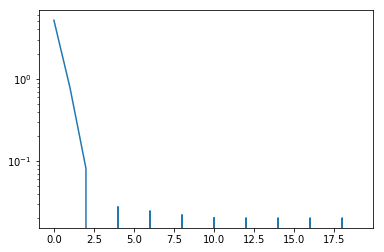

In [70]:
%matplotlib inline
def softmax(w, x):
    mtrx = np.exp(np.dot(x, w.T))
    mtrx /= np.sum(mtrx, axis=1)[:, None] 
    return mtrx  # shape(N, C)

def newton_multiclass(x, y):
    outp = np.dot(x, w.T)
    maxclss = outp.argmax(axis=1)
    # loss = - np.einsum('ij,ij', x, w[y])/N + np.average(outp[np.arange(len(outp)), maxclss]) + lmbd * np.sum(w**2)  # shape(1)
    loss = (- np.sum(x * w[y]) + np.sum(outp[np.arange(N), maxclss])) / N + lmbd * np.sum(w**2)  # shape(1)
    grad = np.stack([- np.sum(x[y==i], axis=0) + np.sum(x[maxclss==i], axis=0) for i in range(class_size)]) / N + 2*lmbd*w # shape(C, D) 　# 近似
    sm = softmax(w, x)  # shape(N, C)
    subsm = np.einsum('ij, ik -> ijk', sm, sm)  # shape(N, C, C)
    subdsm = np.einsum('ij, ki -> kij', np.identity(C), sm)  # shape(N, C, C)
    hess = np.einsum('ijk, il, im', subdsm-subsm, x, x) / N + 2*lmbd # shape(C, C, D, D)
    upd = - np.einsum('ijkl, ik -> ik', np.linalg.pinv(hess), grad) # shape(C, D)
    return loss, upd, maxclss

N, D = x.shape
class_size = 3
epoch_size = 20
lmbd = 0.5
w = np.random.randn(class_size,4)
n_losses = []
n_weights = []

for i in range(epoch_size):
    loss, upd, maxclss = newton_multiclass(x, y)
    w = w + upd
    n_losses.append(loss)
    n_weights.append(w)

n_loss_diff = np.stack(n_losses) - loss
plt.plot(n_loss_diff)
plt.yscale('log')
plt.show()

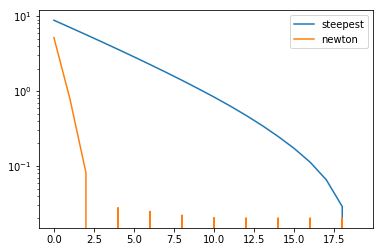

In [71]:
plt.plot(s_loss_diff, label='steepest')
plt.plot(n_loss_diff, label='newton')
plt.yscale('log')
plt.legend()
plt.show()

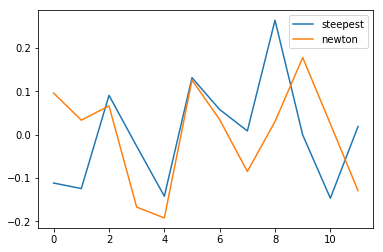

In [74]:
plt.plot(n_weights[-1].flatten(), label='steepest')
plt.plot(s_weights[-1].flatten(), label='newton')
plt.legend()
plt.show()